In [1]:
import sys
import math
from collections import defaultdict
from collections import Counter

import scipy.io.wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

import peakutils
import ltfatpy

from note import Note
import note as notepy
import rion

import pdb


In [2]:
# Interactive inline plots
%matplotlib notebook

In [2]:
# Static inline plots
%matplotlib inline

In [ ]:
# Interactive windowed plots
%matplotlib qt

# Helpers

In [3]:
def plot_note_buckets(note_volumes, loud_notes=[], title='Note buckets', notes=None, new_fig=True):
    '''
    Plots note_volumes of notes into a bar graph.
    '''
    if new_fig:
        plt.figure(figsize = (16,4))
        
    if notes == None:
        notes = notepy.note_range(start=Note('A', 0), end=Note('C', 10))

    plt.bar(np.arange(len(note_volumes)), note_volumes)
    plt.plot(loud_notes, np.zeros(len(loud_notes)), 'ro')
    plt.xticks(np.arange(len(notes)), [note.name + str(note.octave) for note in notes], fontsize=7, rotation=90)
    plt.title(title)
    plt.xlabel('Note')
    plt.ylabel('Volume')
    
def clean_note_buckets(note_volumes, noise_volumes, norm_index=None, fs=44100):
    ''' Put x into note buckets, remove noise, normalize '''
    
    if norm_index == None:
        norm_index = np.argmax(note_volumes)
        
    note_volumes = note_volumes - noise_volumes
    note_volumes[note_volumes < 0] = 0
    note_volumes = note_volumes / note_volumes[norm_index]
    
    return note_volumes

def segment_samples(start_note, end_note, input_width, output_width, note_vol_thresh=0.1, output_offset=0, input_offset=1):
    '''
    Segments a recording of multiple samples which are evenly spaced aprart.
    
    Input
        start_note, end_note: the note range
        input_width: the spacing of each sample
        output_width: the amount of each sample to keep
        note_vol_thresh: a threshold to distinguish sound from noise in the range [0,1]
        output_offset: the shift of the output from the location of beginning of the sound
        input_offset: set to 1 if the first sample width is just noise
        
    Output
        note_samples: dict of samples with Note objects as the key
    '''
    note_samples = {}

    for i, note in enumerate(notepy.note_range(start_note, end_note)):
        sample = x[input_width*(i+input_offset) : input_width*(i+input_offset+1)]
        note_start = np.argmax(sample/np.max(sample)>note_vol_thresh) + output_offset
        note_samples[note] = sample[note_start : note_start+output_width]
        
    return note_samples

def normalize(x):
    return x/np.mean(x)/len(x)

# Sample Import and Preprocess
In these snippets, we import a sample of a piano playing an Ab3/G\#3, recorded through a phone mic.

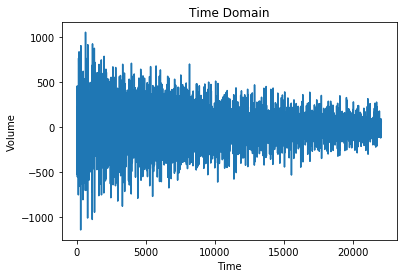

In [4]:
# Load sample
sample_file = 'samples/Intervals_C.wav'
fs, x = scipy.io.wavfile.read(sample_file)
x = x[100000:122050]

plt.plot(x)
plt.title('Time Domain')
plt.xlabel('Time')
plt.ylabel('Volume')

# Load noise sample
noise_sample_file = 'samples/room_noise.wav'
_, x_noise = scipy.io.wavfile.read(noise_sample_file)


# Note Detection
Here, we run a filter on the frequency domain to gather the strength of each note in the timbre.

## Look at Frequency Domain

(0, 5000)

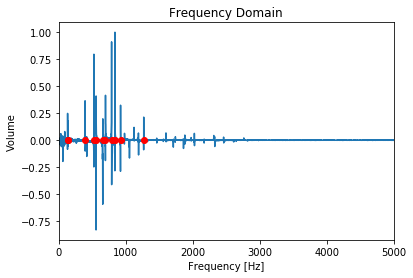

In [5]:
# Take a look at the frequency domain
X = np.real(np.fft.fft(x))
X = X/np.max(X)

peaks = peakutils.indexes(X, thres=0.55/max(X), min_dist=5)

plt.plot(X)
plt.plot(peaks, np.zeros(len(peaks)), 'ro')
plt.title('Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Volume')
plt.xlim([0,5000])


#### Frequency domain stats
Find the peaks in the frequency domain. Those are the notes.

In [6]:
magnitudes, notes = rion.get_notes(x, fs)

print('Notes in timbre, and their magnitudes:')
for magnitude, note, in zip(magnitudes, notes):
    print('{}:\t{:.2f}'.format(note,magnitude))


Notes in timbre, and their magnitudes:
C4+0.02:	0.30
C#4-0.07:	0.17
G5:	0.38
C6+0.02:	1.08
C#6+0.08:	0.39
E6-0.06:	0.36
F6-0.04:	0.38
G6+0.09:	0.57
G#6+0.15:	1.00
Bb6-0.19:	0.21
C#7+0.22:	0.09
Eb7+0.32:	0.21


## Note Buckets
We created a filter which gets the average volume for each note from the frequency domain.

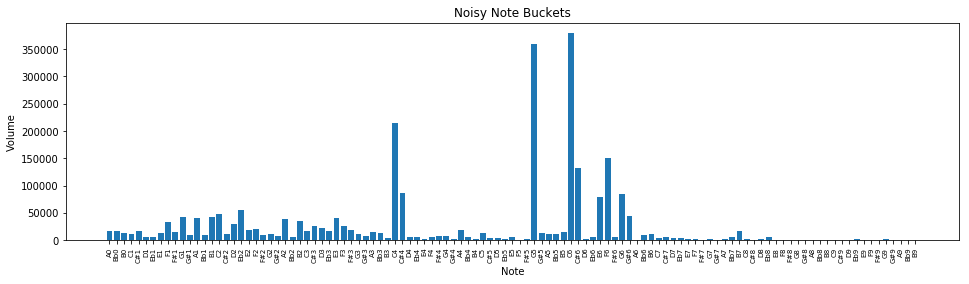

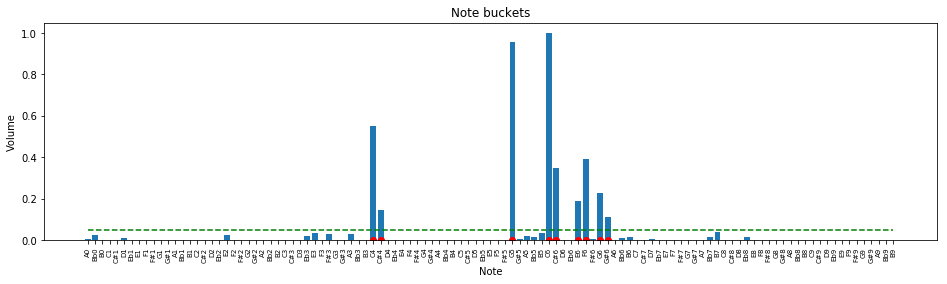

In [7]:
# Put X into note buckets and subtract room noise
# Subtracting noise before bucketing is the same as adding noise
# It either removes the noise or doubles it,
# so we remove noise once we have note volumes
noisy_note_volumes, notes = rion.note_filter(x, fs)
noise_volumes, _    = rion.note_filter(x_noise, fs)
note_volumes = noisy_note_volumes - noise_volumes*0.75
note_volumes[note_volumes < 0] = 0

plot_note_buckets(noisy_note_volumes, title='Noisy Note Buckets')

# Normalize and get octave-normalized note volumes
note_volumes = note_volumes / np.max(note_volumes)
normed_volumes, oct_totals = rion.octave_normalize(note_volumes)
note_names = [note.name + str(note.octave) for note in notes]

# Find loud notes
thresh_val = 0.05
thresh = np.ones(len(note_volumes))*thresh_val
peaks = np.where(note_volumes > thresh)[0]
#peaks = peakutils.indexes(note_volumes, thres=0.02/max(note_volumes), min_dist=1)

plot_note_buckets(note_volumes, peaks)
#plt.bar(np.arange(len(note_volumes)), normed_volumes, alpha=0.25)
plt.plot(thresh, 'g--')


#### Note filter stats
Some statistics that can be gathered from our note filter.


In [8]:
# Get peak notes
peak_notes = [notes[peak] for peak in peaks]
print('Notes in timbre are {}\n'.format([str(peak_note) for peak_note in peak_notes]))
f_0 = peak_notes[0]
print('f_0 is {}\n'.format(f_0))

# Peak tone count
print('Timbre tone count:')
peak_tones = dict(Counter([peak_note.name for peak_note in peak_notes]))
for w in sorted(peak_tones, key=peak_tones.get, reverse=True):
    print('{}\t{}'.format(w, peak_tones[w]))

# Sum of tone strengths
print('\nSum of tone strengths:')
tone_sums = defaultdict(int)
for note, vol in zip(notes, note_volumes):
    tone_sums[note.name] += vol
for w in sorted(tone_sums, key=tone_sums.get, reverse=True):
    print('{}\t{}'.format(w, round(tone_sums[w],3)))


Notes in timbre are ['C4', 'C#4', 'G5', 'C6', 'C#6', 'E6', 'F6', 'G6', 'G#6']

f_0 is C4

Timbre tone count:
C	2
C#	2
G	2
E	1
F	1
G#	1

Sum of tone strengths:
C	1.549
G	1.188
C#	0.495
F	0.39
E	0.244
G#	0.114
B	0.089
Bb	0.062
A	0.061
F#	0.035
Eb	0.032
D	0.015


### Timbre Filter
This is a filter of the timbre of a a note. It has the strength of different harmonics with the 0th index storing the strength of the fundamental frequency, and each following index is a semitone higher.

Todo: test if the timbre of an instrument changes in different octaves.

In [4]:
def build_timbre_filter(note_buckets, loud_notes):
    ''' Returns a note filter of the shape of the timbre '''
    for i in range(len(note_buckets)):
        if i not in loud_notes:
            note_buckets[i] = 0
    timbre_filter = note_buckets[loud_notes[0]:loud_notes[-1]+1]
    timbre_filter = timbre_filter / timbre_filter[0]
    return timbre_filter

def apply_timbre_filter(timbre_filter, note, notes=None):
    ''' 
    Applies timbre filter with f0 as note in the spectrum of notes
    Returns note buckets
    '''
    if notes == None:
        notes = notepy.note_range(Note('A', 0), Note('C', 10))
    
    note_buckets = np.zeros(len(notes))
    start_index = notes.index(note)
    end_index = start_index + len(timbre_filter)
    
    if len(note_buckets) < start_index + len(timbre_filter):
        timbre_filter = timbre_filter[:len(note_buckets)-start_index]
        end_index = len(note_buckets)
    
    note_buckets[start_index : end_index] = timbre_filter
    return note_buckets


<IPython.core.display.Javascript object>


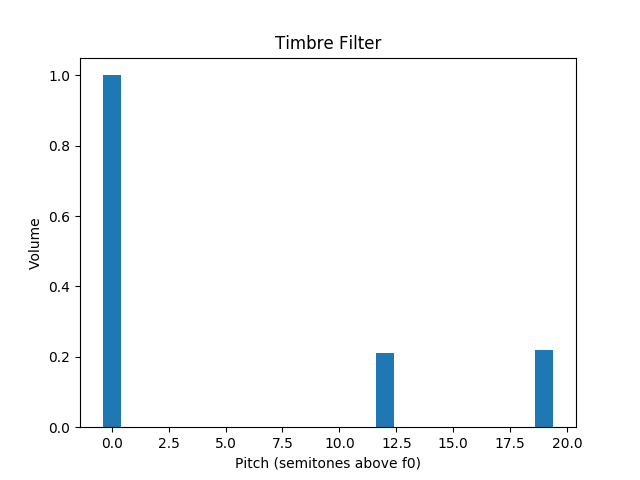

Text(0,0.5,'Volume')

In [38]:
fs, x = scipy.io.wavfile.read('samples/clean_c#.wav')
x = x[:fs//8]
note_volumes, notes = rion.note_filter(x, fs)
note_volumes = note_volumes / np.max(note_volumes)
timbre_filter = build_timbre_filter(note_volumes, np.where(note_volumes > 0.1)[0])

plt.bar(np.arange(len(timbre_filter)), timbre_filter)
plt.title('Timbre Filter')
plt.xlabel('Pitch (semitones above f0)')
plt.ylabel('Volume')

# Multiple Note Detection
We can use the note buckets and timbre filter to detect multiple notes.
### Import Samples... and more
Here, we import a sample of a 2-note chord as well as samples of each of the notes being played individually.

(5000, 6000)

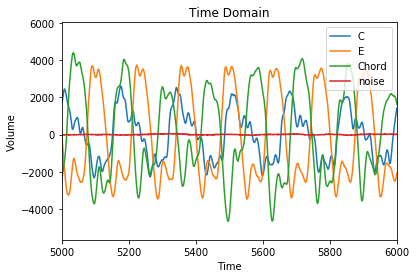

In [11]:
note1 = Note('C', 4)
note2 = Note('E', 4)

input_width = 2*fs # a note is played every input_width seconds
output_width = int(0.5*fs) # we will only use output_width of the sample
note_vol_thresh = 0.1 # vol above thresh is not noise

# Load sample
sample_file = 'samples/chords2_c4.wav'
fs, x = scipy.io.wavfile.read(sample_file)

chrd_samples = segment_samples(Note('C#', 4), Note('C#', 5), input_width, output_width)

# Cut a chord from sample
x_chrd = chrd_samples[note2]

# Load recording of individual notes
sample_file = 'samples/chromatic_c4_eb7.wav'
fs, x = scipy.io.wavfile.read(sample_file)

note_samples = segment_samples(Note('C', 4), Note('E', 7), input_width, output_width)
    
# Assign the notes which we are looking for to variables
x_note1 = note_samples[note1]
x_note2 = note_samples[note2]
x_both  = (x_note1 + x_note2)/2

# Load noise sample
noise_sample_file = 'samples/room_noise.wav'
_, x_noise = scipy.io.wavfile.read(noise_sample_file)
noise_volumes, notes    = rion.note_filter(x_noise, fs) # TODO:, noise should look at each note range instead of exact note bucket(s)

# Get timbre of each note
note_timbres = [clean_note_buckets(rion.note_filter(sample)[0], noise_volumes, norm_index=notes.index(note)) for note, sample in note_samples.items()]

# Or.. you can simply use a timbre filter (might not be as effective)
model_note = Note('C', 4)
model_note_timbre, _ = rion.note_filter(note_samples[model_note], fs)
model_note_timbre = clean_note_buckets(model_note_timbre, noise_volumes, fs=fs)
model_loud_notes = np.where(model_note_timbre > 0.2)[0]
timbre_filter = build_timbre_filter(model_note_timbre, model_loud_notes)

plt.plot(x_note1, label = note1.name)
plt.plot(x_note2, label = note2.name)
plt.plot(x_chrd, label = 'Chord')
plt.plot(x_noise, label='noise')
plt.title('Time Domain')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()
plt.xlim((5000,6000))

### Compare frequency domains
Plot the frequency domains of the chord and a signal of the two notes added together.

(0, 2000)

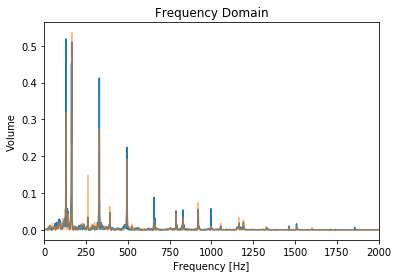

In [12]:
X_chrd = np.real(np.fft.fft(x_chrd))
X_both = np.real(np.fft.fft(x_both))

X_chrd = normalize(X_chrd)
X_both = normalize(X_both)

plt.plot(np.abs(X_chrd))
plt.plot(np.abs(X_both), alpha=0.5)
plt.title('Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Volume')
plt.xlim([0,2000])


## Detect Notes in Chord

In [43]:
def detect_notes(chrd_volumes, timbre, notes=None, fs=44100, loud_thresh=0.2, error_thresh=0.5, confidence_thresh=0.25, plot=False):
    chrd_notes = []
    chrd_note_volumes = []
    errors = []
    confidences = []
    
    tibmre = np.array(timbre)
    use_timbre_filter = True if len(timbre.shape)==1 else False

    if notes == None:
        notes = notepy.note_range(start=Note('A', 0), end=Note('C', 10))
    
    chrd_volumes[chrd_volumes < 0] = 0
    chrd_volumes = chrd_volumes / np.max(chrd_volumes) # TODO: can instead divide by mean -- normalizing to overall volume to accomadate for quieter notes

    loud_notes = np.where(chrd_volumes > loud_thresh)[0]

    while len(loud_notes) > 0:

        if plot:
            plot_note_buckets(chrd_volumes, loud_notes, title='Chord Timbre without {}'.format(chrd_notes))

        # Get first note's timbre
        f0 = notes[loud_notes[0]]
        if use_timbre_filter:
            note_volumes = apply_timbre_filter(timbre, f0, notes)
        else:
            note_volumes = timbre[f0]

        if plot:
            plt.bar(np.arange(len(note_volumes)), note_volumes*chrd_volumes[notes.index(f0)], alpha=0.5)

        # Subtract first note's timbre from the chord's timbre
        chrd_volumes_less_f0 = chrd_volumes - note_volumes*chrd_volumes[notes.index(f0)]

        # Calculate confidence to determine if note really part of timbre
        y = chrd_volumes_less_f0[notes.index(f0):]
        error = np.sum(np.where(y < 0, abs(y), 0)**2)
        volume = chrd_volumes[notes.index(f0)]
        confidence = volume*(error_thresh-error)/error_thresh

        if confidence > confidence_thresh:
            chrd_notes.append(f0)
            chrd_note_volumes.append(volume)
            errors.append(error)
            confidences.append(confidence)

            chrd_volumes = chrd_volumes_less_f0
            chrd_volumes[chrd_volumes < 0] = 0
        else:
            print('{} failed with confidence {:.2}'.format(f0, confidence))
            chrd_volumes[notes.index(f0)] = 0

        # Find loud notes
        loud_notes = np.where(chrd_volumes > loud_thresh)[0]
        
    return chrd_notes, np.array(chrd_note_volumes), errors, confidences

def print_detection_info(chrd_notes, chrd_note_volumes, errors, confidences):
    print('Notes in Chord\nNote\tVolume\tError\tConfidence')
    for i in range(len(chrd_notes)):
        print('{}\t{:.2f}\t{:.2f}\t{:.2f}'.format(chrd_notes[i], chrd_note_volumes[i], errors[i], confidences[i]))

In [14]:
chrd_volumes, notes = rion.note_filter(x_chrd, fs)
chrd_volumes = chrd_volumes - noise_volumes

# confidence_thresh = 0.25
# error_thresh = 0.5
# loud_thresh = 0.20

chrd_notes, chrd_note_volumes, errors, confidences = detect_notes(chrd_volumes, timbre_filter, notes, fs)
print_detection_info(chrd_notes, chrd_note_volumes, errors, confidences)

Notes in Chord
Note	Volume	Error	Confidence
C4	1.00	0.20	0.60
E4	0.63	0.00	0.63
E5	0.29	0.01	0.28


#### More challenging samples

<IPython.core.display.Javascript object>


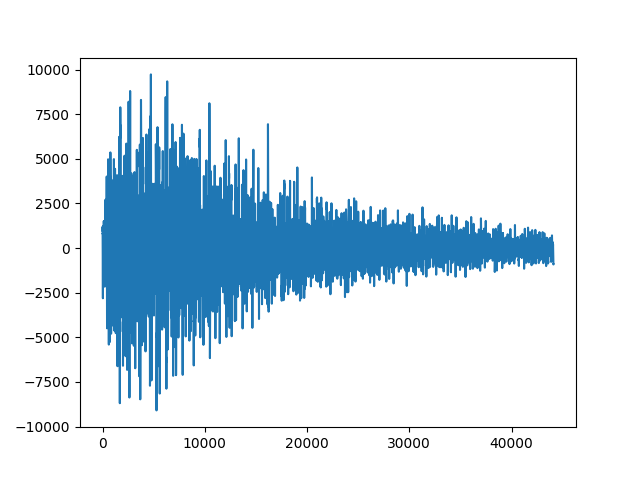

In [35]:
# Load sample
sample_files = ['samples/Ab3C4Eb4.wav',       # easy mode
                'samples/Eb4G4Ab4C5.wav',   # medium mode
                'samples/DEFA5.wav',        # medium mode
                'samples/B1B2A3C#4E4G#4.wav'] # hard mode
x_challenges = []
for sample_file in sample_files:
    fs, x = scipy.io.wavfile.read(sample_file)
    x_challenges.append(x)

x_challenges[0] = x_challenges[0][20000:20000+22050]
x_challenges[1] = x_challenges[1][25500:25500+int(22050)]
x_challenges[2] = x_challenges[2][29700:29700+int(22050*2)]
x_challenges[3] = x_challenges[3][29000:29000+int(22050*2)]

x_chrd = x_challenges[3]

plt.plot(x_chrd)

# Dealing with Time
## Sample Width
How does the width of the sample affect the accuracy and shape of the note buckets?

From our pleliminary experiemnts, results become less stable as sample width decreases, however, sometimes changing the sample width can reveal new features.

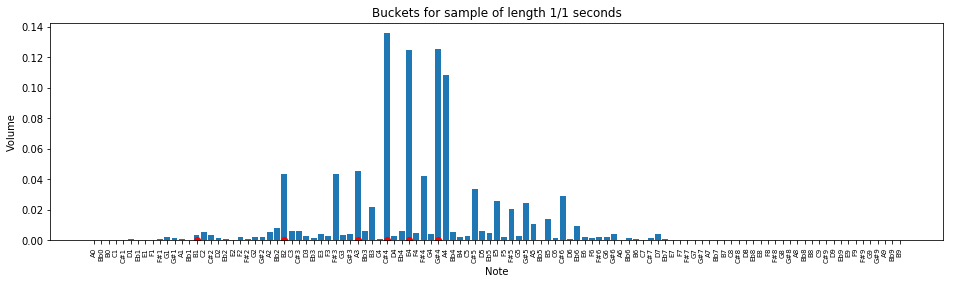

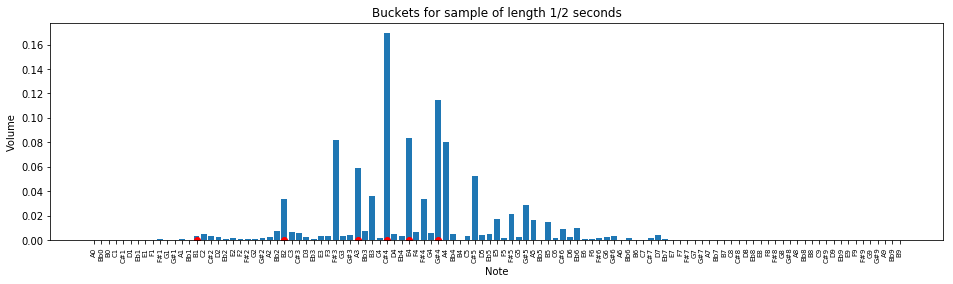

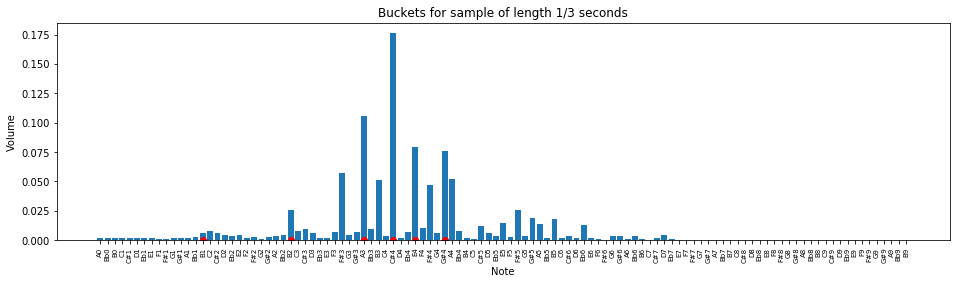

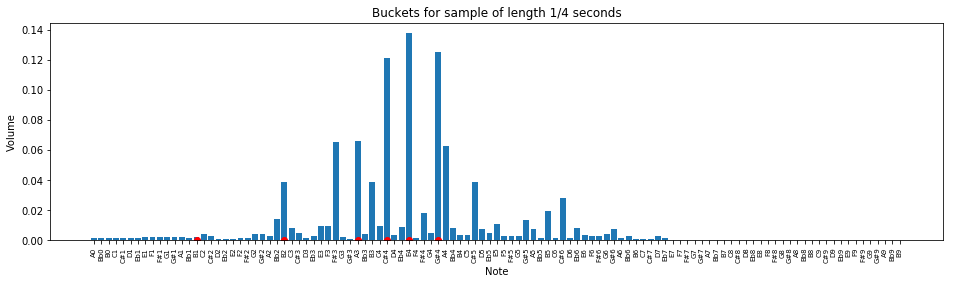

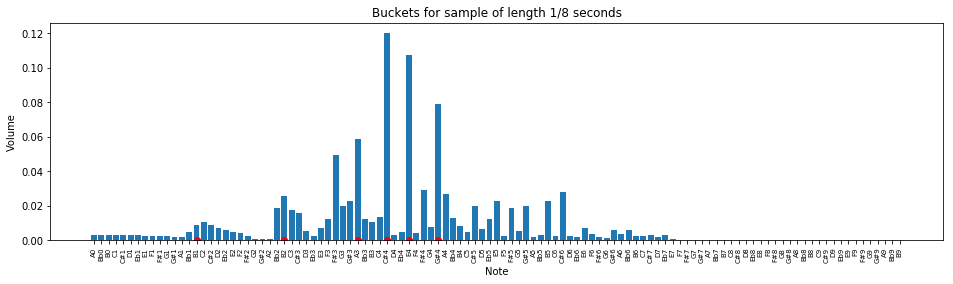

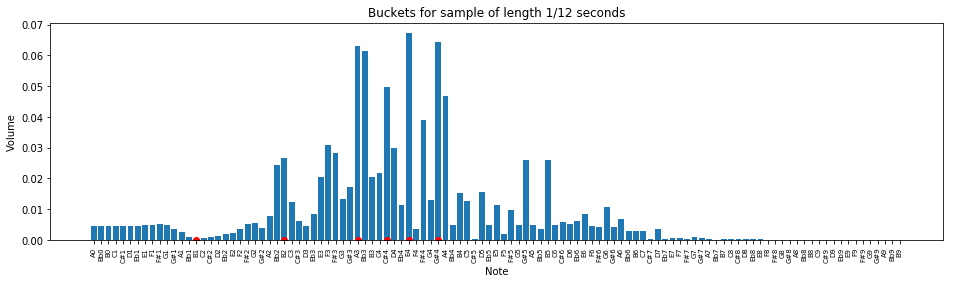

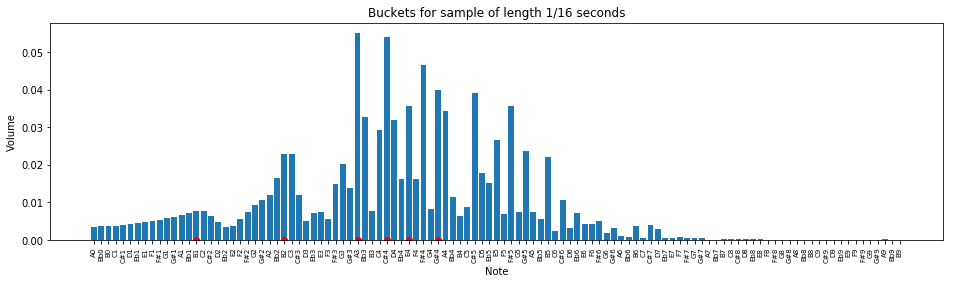

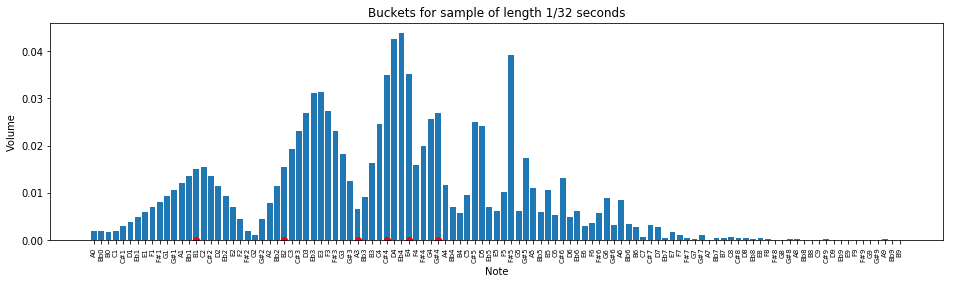

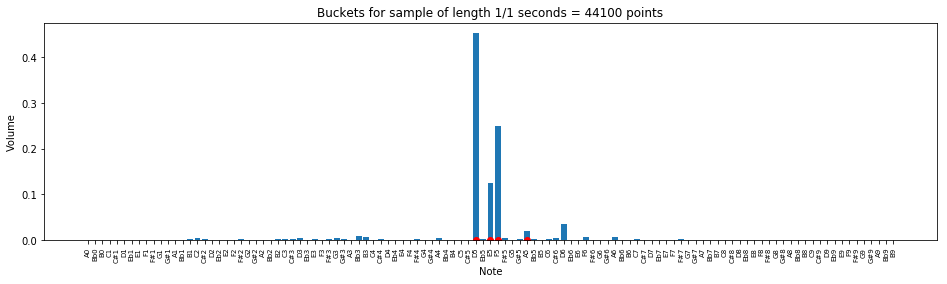

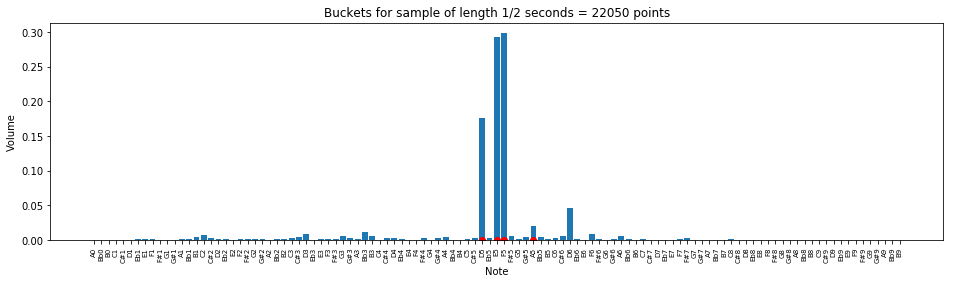

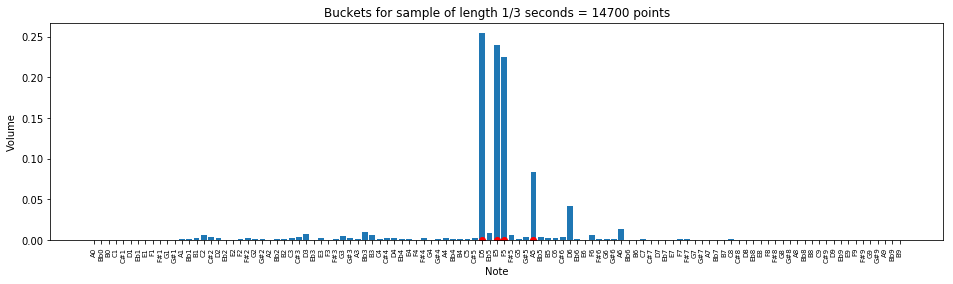

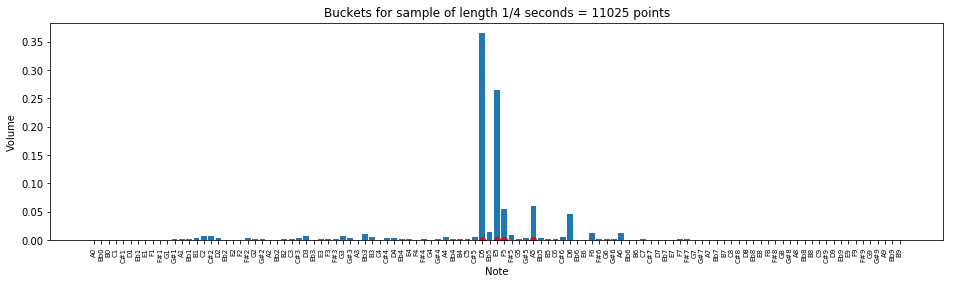

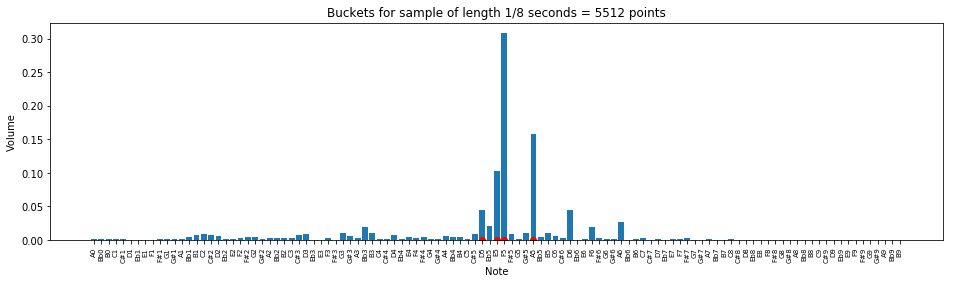

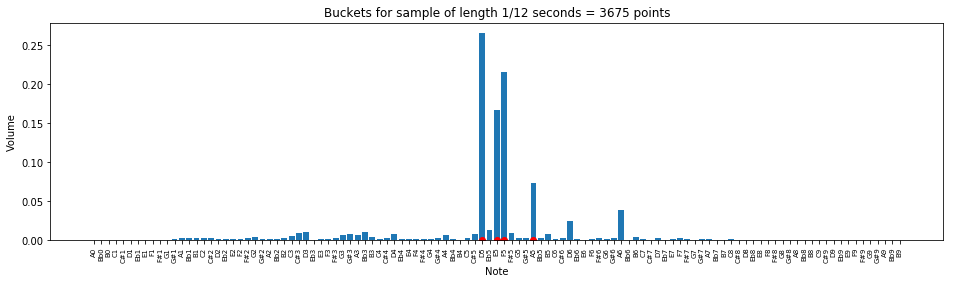

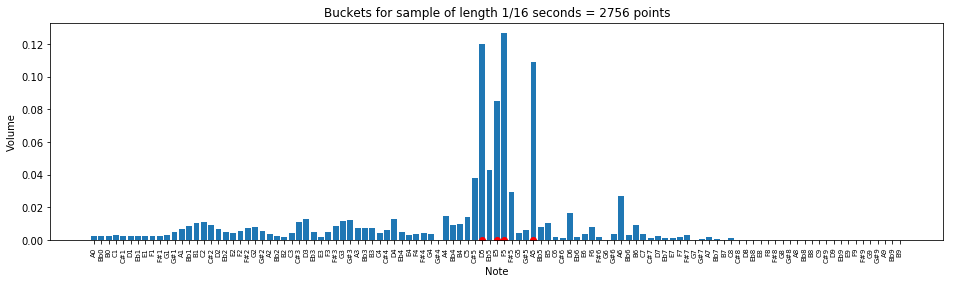

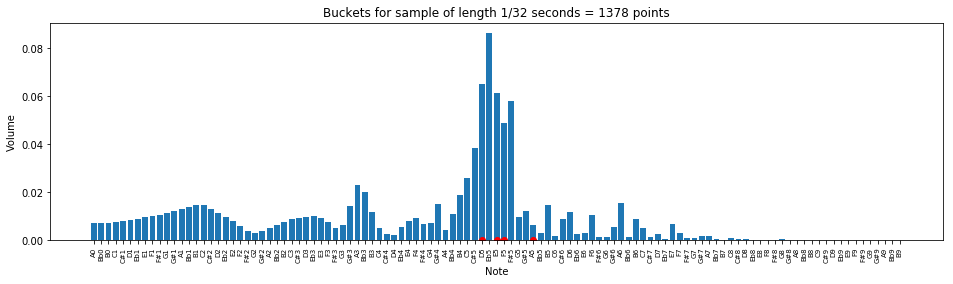

In [16]:
x = x_challenges[3]
truth = np.array([Note('B',1), Note('B',2), Note('A', 3), Note('C#', 4), Note('E', 4), Note('G#', 4)])
truth_idxs = np.where(np.in1d(notes,truth))[0]

for fraction in [1,2,3,4,8,12,16,32]:
    note_buckets, notes = rion.note_filter(x[:fs//fraction])
    note_buckets = normalize(note_buckets)
    plot_note_buckets(note_buckets, truth_idxs, title='Buckets for sample of length 1/{} seconds'.format(fraction))
    

x = x_challenges[2]
truth = np.array([Note('D', 5), Note('E', 5), Note('F', 5), Note('A', 5)])
truth_idxs = np.where(np.in1d(notes,truth))[0]

for fraction in [1,2,3,4,8,12,16,32]:
    note_buckets, notes = rion.note_filter(x[:fs//fraction])
    note_buckets = normalize(note_buckets)
    plot_note_buckets(note_buckets, truth_idxs, title='Buckets for sample of length 1/{} seconds = {} points'.format(fraction, fs//fraction))


## Detecting when notes are played
We can detect new notes when there are spikes in volume. We smooth the absolute values of the audio with a Gaussian filter, and take its first and second derivatives to find peaks in volume. Instead of accepting all peaks, we   

In [30]:
def find_play_times(x, atk_thresh=0.05, filt_size=10, plot=False):
    # Abs and smooth audio
    filt = scipy.signal.gaussian(1024*filt_size, 128*filt_size)
    x = np.convolve(np.abs(x), filt, 'same')
    x = x/np.max(x)

    # First derivative
    xp = np.gradient(x)
    xp = np.convolve(xp, filt, 'same')
    xp = xp/np.max(xp)

    # Second derivative
    xpp = np.gradient(xp)
    xpp = np.convolve(xpp, filt, 'same')
    xpp = xpp/np.max(xpp)

    # Note start times
    play_times = np.where(np.logical_and(np.diff(np.sign(xpp)), xp[1:]>atk_thresh))[0]

    if plot:
        plt.plot(x, label="f(x)")
        plt.plot(xp, label="f'(x)")
        plt.plot(xpp, label="f''(x)")
        plt.plot(play_times, np.zeros(len(play_times)), 'ro', label='play times')
        plt.title('Note play times')
        plt.xlabel('Time')
        plt.legend()

    return play_times

<IPython.core.display.Javascript object>


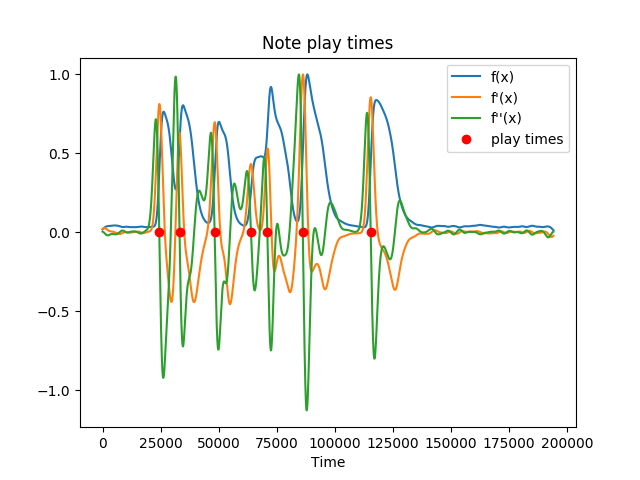

<IPython.core.display.Javascript object>


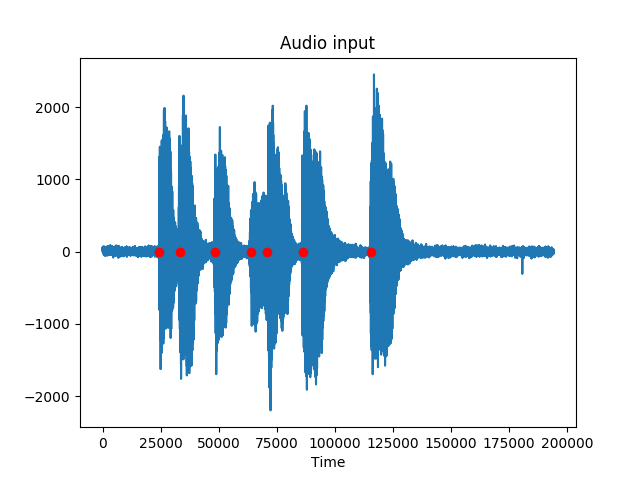

In [31]:
song_name = 'mario'
fs, x = scipy.io.wavfile.read('samples/{}.wav'.format(song_name))
play_times = find_play_times(x, atk_thresh=0.03, filt_size=7, plot=True)

plt.figure()
plt.plot(x)
plt.plot(play_times, np.zeros(len(play_times)), 'ro')
plt.title('Audio input')
plt.xlabel('Time')

# Add blip to audio at play times to debug (and for fun)
x_debug = x.copy()
_, blip = scipy.io.wavfile.read('samples/debug/blip.wav')
for t in play_times:
    x_debug[t:t+len(blip)] = x_debug[t:t+len(blip)] + blip
    
scipy.io.wavfile.write('samples/out/{}_blip.wav'.format(song_name), fs, x_debug)

# Putting it together: music decomposition
We are now going to apply our note detection to each play-time in the recording – with a twist. 

## Dealing with sustained notes
Notes are commonly sustained for a long period of time, which means that they may be prominent in a timbre long after they have been played. For example, an A is played at $t=1$, then at $t=2$, a C# is played, while the A is still sustained. Both the A and the C# will be detected through note detection, while the C# is the only note that was being played at $t=2$. How do we know wheather A was played or sustained? 

To eliminate this problem, we can look at the note volumes between each play-time. If the same note is detected in two consecutive play-times, we can calculate note volumes from before the second play-time, and compare it to the volume at the second play-time. If the volume increased, the note was played, otherwise it was sustained.

#### Original note volumes
Our note detection is performed in a normalized setting. To recover the original note volumes, we can multiply the normalized volumes by segment's absolute volume.

In [39]:
def sample_volume(x):
    return np.mean(np.abs(x))


In [46]:
x_chrd = x_challenges[3]

chrd_volumes, notes = rion.note_filter(x_chrd, fs)
chrd_notes, chrd_note_volumes, errors, confidences = detect_notes(chrd_volumes, timbre_filter, notes=notes)
chrd_note_volumes = chrd_note_volumes * sample_volume(x_chrd)
print_detection_info(chrd_notes, chrd_note_volumes, errors, confidences)

C#6 failed with confidence 0.21
Notes in Chord
Note	Volume	Error	Confidence
B2	386.40	0.00	0.32
F#3	385.26	0.00	0.32
A3	402.29	0.00	0.33
C#4	1204.80	0.00	0.99
E4	1107.85	0.02	0.89
G#4	1109.02	0.06	0.82
A4	878.06	0.03	0.69
